<a href="https://colab.research.google.com/github/monicafebyana-wq/Tugas_Besar_AI-Kelompok2_TK4703/blob/main/Code/TUBES_AI_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Klasifikasi Tingkat Kematangan Tomat Berbasis Pengenalan Pola Citra Digital Menggunakan Algoritma K-Nearest Neighbors (KNN)**

Kelompok 2:

- Cheyza Amanda Syafira (101032300081)
- Rahmad Hamdi Siregar (101032330026)
- Monica Febyana (101032330068)

In [ ]:
import kagglehub

path = kagglehub.dataset_download("enalis/tomatoes-dataset")

print("Path to dataset files:", path)

100%|██████████| 93.7M/93.7M [00:00<00:00, 195MB/s]


Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/enalis/tomatoes-dataset/versions/4


In [ ]:
import os
import cv2
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

split_folders = ['train', 'val']
class_names = ['Damaged', 'Old', 'Ripe', 'Unripe']

## **Preprocessing**

In [ ]:
import os
import shutil
import random
from collections import defaultdict

old_base_dir = path + "/content/ieee-mbl-cls"
new_base_dir = "/root/.cache/kagglehub/datasets/enalis/tomatoes-dataset/versions/4/content/ieee-mbl-cls/data8020"
splits = ["train", "val"]
train_ratio = 0.8
random.seed(42)

all_images = defaultdict(list)

for split in splits:
    split_path = os.path.join(old_base_dir, split)
    for label in os.listdir(split_path):
        label_path = os.path.join(split_path, label)
        if not os.path.isdir(label_path):
            continue
        for img in os.listdir(label_path):
            all_images[label].append(os.path.join(label_path, img))

for split in ["train", "val"]:
    for label in all_images.keys():
        os.makedirs(os.path.join(new_base_dir, split, label), exist_ok=True)

for label, images in all_images.items():
    random.shuffle(images)
    split_idx = int(len(images) * train_ratio)

    train_imgs = images[:split_idx]
    val_imgs = images[split_idx:]

    for img_path in train_imgs:
        shutil.copy(
            img_path,
            os.path.join(new_base_dir, "train", label, os.path.basename(img_path))
        )

    for img_path in val_imgs:
        shutil.copy(
            img_path,
            os.path.join(new_base_dir, "val", label, os.path.basename(img_path))
        )

print("Resplit selesai: 80% train - 20% val (stratified)")

Resplit selesai: 80% train - 20% val (stratified)


In [ ]:
def extract_color_histogram(image_path, size=(64,64), bins=(8,8,8)):
    img = cv2.imread(image_path)
    img = cv2.resize(img, size)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, np.array([0, 20, 20]), np.array([180, 255, 255]))
    hist = cv2.calcHist([hsv], [0,1,2], mask, bins, [0,180,0,256,0,256])
    hist = cv2.normalize(hist, hist).flatten()
    return hist, hsv

In [ ]:
X_train, y_train = [], []
X_val, y_val = [], []
sample_images = []

le = LabelEncoder()

all_train_hsv = []

for split in split_folders:
    split_path = os.path.join(new_base_dir, split)
    for label in class_names:
        label_path = os.path.join(split_path, label)
        if not os.path.exists(label_path):
            continue
        for img_name in tqdm(os.listdir(label_path), desc=f'Processing {split}/{label}'):
            img_path = os.path.join(label_path, img_name)
            features, hsv_img = extract_color_histogram(img_path)

            if split == 'train':
                X_train.append(features)
                y_train.append(label)
                all_train_hsv.append((hsv_img, label))
            else:
                X_val.append(features)
                y_val.append(label)

num_samples = 6
sample_images = random.sample(all_train_hsv, num_samples)

X_train = np.array(X_train)
X_val = np.array(X_val)

y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)

print("\n\nTrain data shape:", X_train.shape)
print("Validation data shape:", X_val.shape)
print("Label classes:", le.classes_)

Processing val/Unripe: 100%|██████████| 353/353 [00:00<00:00, 1138.22it/s]



Train data shape: (5780, 512)
Validation data shape: (1446, 512)
Label classes: ['Damaged' 'Old' 'Ripe' 'Unripe']


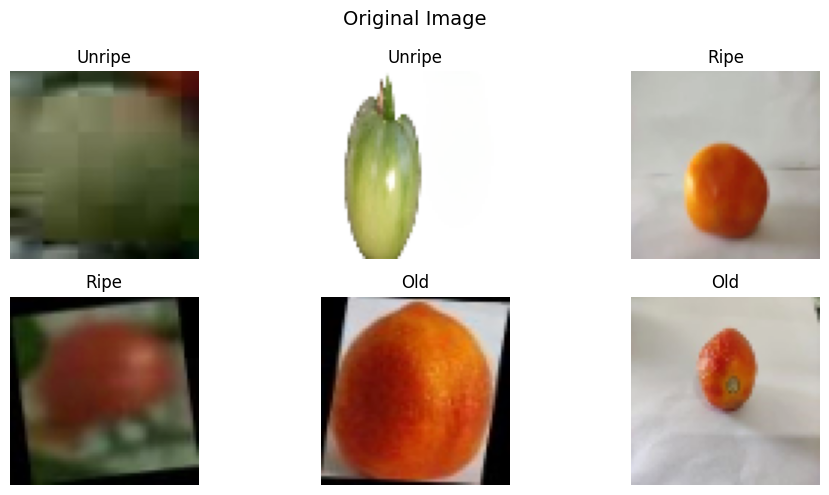

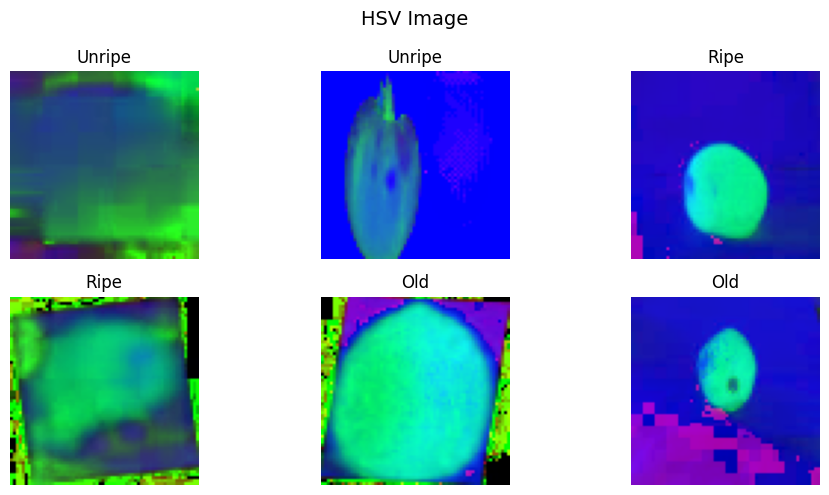

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(10, 5))
fig.suptitle("Original Image", fontsize=14)
for ax, (img, label) in zip(axes.flatten(), sample_images):
    rgb_img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)
    ax.imshow(rgb_img)
    ax.set_title(label)
    ax.set_axis_off()
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 3, figsize=(10, 5))
fig.suptitle("HSV Image", fontsize=14)
for ax, (img, label) in zip(axes.flatten(), sample_images):
    ax.imshow(img)
    ax.set_title(label)
    ax.set_axis_off()
plt.tight_layout()
plt.show()


## **Training & Testing**

Sedang menganalisis grafik K (Elbow Method)...


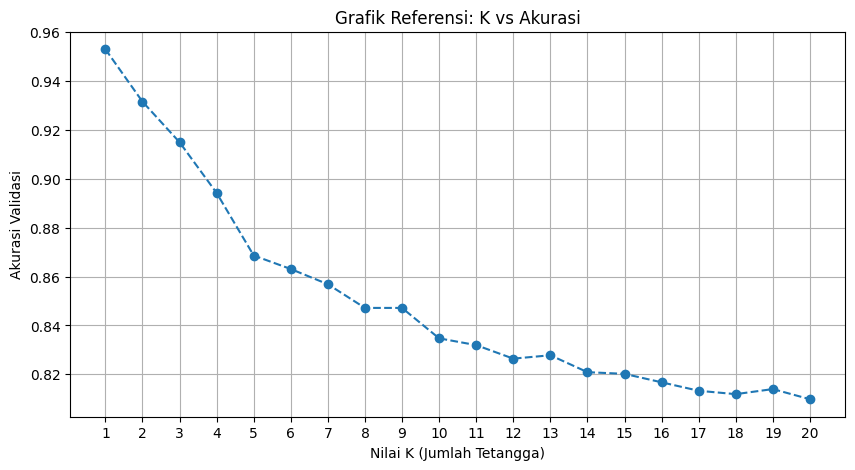

Saran Komputer (Berdasarkan Skor Tertinggi): K=1

KEPUTUSAN FINAL: Model dilatih menggunakan K=3 (Voting 3 Tetangga)

AKURASI MODEL (K=3): 91.49%

Laporan Klasifikasi:
              precision    recall  f1-score   support

     Damaged       0.87      0.76      0.81       211
         Old       0.89      0.93      0.91       443
        Ripe       0.93      0.91      0.92       439
      Unripe       0.95      0.99      0.97       353

    accuracy                           0.91      1446
   macro avg       0.91      0.90      0.90      1446
weighted avg       0.91      0.91      0.91      1446



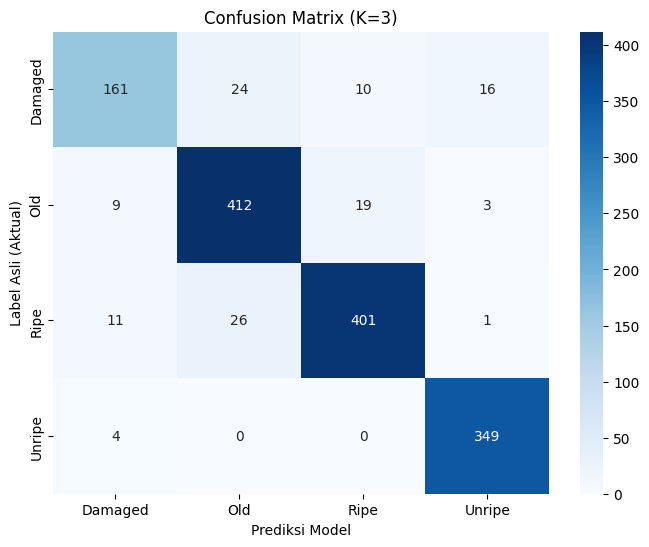

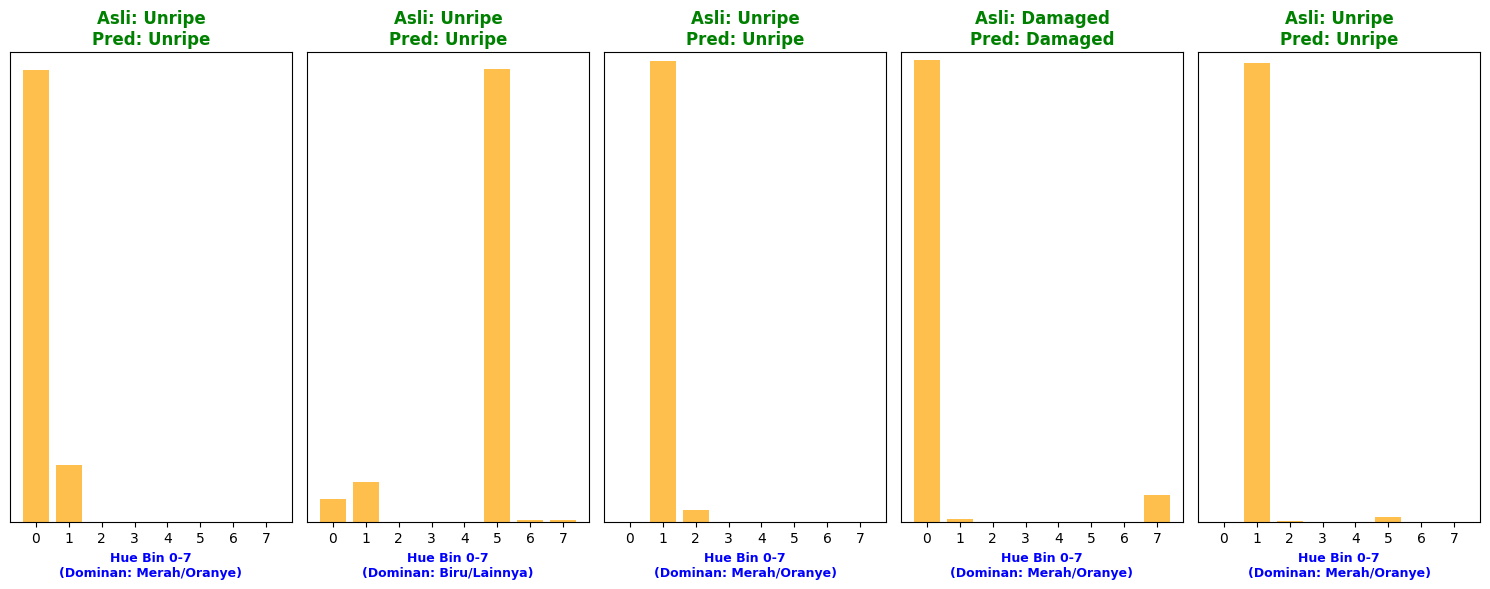

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

k_range = range(1, 21)
scores = []

print("Sedang menganalisis grafik K (Elbow Method)...")
for k in k_range:
    knn_temp = KNeighborsClassifier(n_neighbors=k)
    knn_temp.fit(X_train, y_train)
    scores.append(knn_temp.score(X_val, y_val))

plt.figure(figsize=(10, 5))
plt.plot(k_range, scores, marker='o', linestyle='dashed')
plt.xlabel('Nilai K (Jumlah Tetangga)')
plt.ylabel('Akurasi Validasi')
plt.title('Grafik Referensi: K vs Akurasi')

plt.xticks(k_range)
plt.grid(True)
plt.show()

rekomendasi_k = k_range[np.argmax(scores)]
print(f"Saran Komputer (Berdasarkan Skor Tertinggi): K={rekomendasi_k}")

FIX_K = 3

knn = KNeighborsClassifier(n_neighbors=FIX_K)
knn.fit(X_train, y_train)

print(f"\nKEPUTUSAN FINAL: Model dilatih menggunakan K={FIX_K} (Voting 3 Tetangga)")

y_pred = knn.predict(X_val)

acc = accuracy_score(y_val, y_pred)
print(f"\nAKURASI MODEL (K={FIX_K}): {acc * 100:.2f}%")

print("\nLaporan Klasifikasi:")
print(classification_report(y_val, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel('Prediksi Model')
plt.ylabel('Label Asli (Aktual)')
plt.title(f'Confusion Matrix (K={FIX_K})')
plt.show()

indices = np.random.choice(len(X_val), 5, replace=False)

plt.figure(figsize=(15, 6))

for i, idx in enumerate(indices):
    plt.subplot(1, 5, i+1)

    pred_label_idx = knn.predict([X_val[idx]])[0]
    pred_label = le.inverse_transform([pred_label_idx])[0]
    true_label = le.inverse_transform([y_val[idx]])[0]

    if len(X_val[idx]) == 512:
        hist_3d = X_val[idx].reshape((8, 8, 8))
        hue_profile = hist_3d.sum(axis=(1, 2))

        dominan_bin = np.argmax(hue_profile)
        if dominan_bin in [0, 1, 7]: info_warna = "Dominan: Merah/Oranye"
        elif dominan_bin in [2, 3, 4]: info_warna = "Dominan: Hijau"
        else: info_warna = "Dominan: Biru/Lainnya"

        plt.bar(range(8), hue_profile, color='orange', alpha=0.7)
        plt.xlabel(f"Hue Bin 0-7\n({info_warna})", fontsize=9, fontweight='bold', color='blue')
        plt.ylim(0, max(hue_profile)+0.05)
        plt.xticks(range(8))
        plt.yticks([])
    else:
        plt.plot(X_val[idx])

    color = 'green' if pred_label == true_label else 'red'
    plt.title(f"Asli: {true_label}\nPred: {pred_label}", color=color, fontweight='bold')

plt.tight_layout()
plt.show()